---
>「あなたが宇宙を理解することを望むなら、エネルギー、周波数、振動の観点から考えなさい。」\
>二コラ・テスラ
---

# 音の分類

今回は、音を扱う。画像処理、テキスト処理、となれば、あとは音声処理ということになる

ただ、やることは基本的に同じである

# メルスペクトグラムの利用

音声処理にも様々な手法が存在する。従来はHMMが用いられたが、現在の主流はDNNの利用である

DNNを利用する際に、音声をそのまま波形データとして処理させることも可能といえば可能である
- 実際には処理コストが高く、かなりやっかいであることがわかる
- DNNは画像認識分野で発展が著しいため、これを応用すると考えるのは当然である
- そこで、音声を画像化するメルスペクトグラムの利用が想定され、音声解析手法としてよく利用されている

## 学習に用いるデータの取得


ESC-50データセットを利用する
- 環境音の分類手法ベンチマークとして準備されており、2000個の環境音がラベル付きで保存されている
- 5秒間の録音を50のクラス（1クラスあたり40例）収録されており、5つの主要なカテゴリーに大まかに分類されている

|動物|自然の音風景・水の音|人間・非音声の音|室内・家庭内の音|外・都市の音|
|-|-|-|-|-|
|犬|雨|赤ん坊の泣き声|ドアノック|ヘリ|
|雄鶏|海の波|くしゃみ|マウスクリック|チェーンソー|
|豚|燃える火|拍手|キーボード打鍵|サイレン|
|牛|コオロギ|呼吸|ドア・木のきしみ|車のクラクション|
|カエル|鳥のさえずり|咳をする|缶を開ける|エンジン|
|猫|水滴|足音|洗濯機|電車|
雌鶏|風|笑い声|掃除機|教会の鐘|
|飛んでいる虫|水撒き|歯磨き|時計のアラーム|飛行機|
|羊|トイレの水洗|いびき|時計の音|花火|
|カラス|雷雨|飲む・すする|グラスを割る|鋸|

In [3]:
!pip install gdown
import os
if not os.path.exists('ESC-50-master/LICENSE'):
  !gdown 1OiP_cuLUVe4c0HzUB-vro4Jm106w_lOo
  !unzip -q ESC-50-master.zip

Downloading...
From (original): https://drive.google.com/uc?id=1OiP_cuLUVe4c0HzUB-vro4Jm106w_lOo
From (redirected): https://drive.google.com/uc?id=1OiP_cuLUVe4c0HzUB-vro4Jm106w_lOo&confirm=t&uuid=b508ab45-7092-447a-a850-34435ccfe128
To: /content/ESC-50-master.zip
100% 646M/646M [00:06<00:00, 93.9MB/s]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


次に、データセットに関する各種設定と確認、さらにラベルデータの取得を行う

In [5]:
import pandas as pd

# Google Drive上に格納した環境音データセットのディレクトリを指定しておく
drive_dir = "ESC-50-master/"

# メタファイル（ファイル名にカテゴリーなどが紐づいた情報）がcsvファイルとして格納されているので、DataFrameで持っておく
meta_df = pd.read_csv(drive_dir + "meta/esc50.csv")

# メタファイルを確認する
display(meta_df.head())

# 全カテゴリーを取得して確認する
categories = meta_df['category'].unique()
print("データセットの数", meta_df.shape[0])
print(len(categories), categories[:10]) # いくつかカテゴリーを表示してみる
# データセットの数 2000
# 50 ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock' 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


データセットの数 2000
50 ['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw']


必要なライブラリを読み込む

In [6]:
import os
import pandas as pd
from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## 音響特徴量「メルスペクトル」と「MFCC（メル周波数ケプストラム係数）」

音響特徴量の利用
- 単純に収音データ（信号波形）をモデルに入力しただけでは上手くいかないことが多く学習する上で重要な情報とそうでない情報とを考慮する必要がある
- 一般に、音データのような信号波形ではフーリエ変換したスペクトルを起点に考えることが多く、これから得られる重要な情報のことを音響特徴量と呼ぶ
- 音響特徴量として、「メルスペクトル」と「MFCC（メル周波数ケプストラム係数）」が著名で、音声認識の分野では非常に馴染みの深い特徴量

### 波形

単に音をサンプリングし、その値を時系列で示したグラフ

### スペクトル

ある信号波形をあらゆる周波数の正弦波の合成の形で分解し、各周波数成分の強さを得るためにフーリエ変換を利用する
- この時の各周波数成分の強さを示したグラフを信号波形のパワースペクトルと呼ぶ
- サンプリング周波数がCD音質、つまり44100Hzのとき、サンプリング定理から半分の22050Hz（ナイキスト周波数と呼ぶ）まで周波数成分の強さを見ることができる
- 詳細は後述するが、音響解析では特に短時間フーリエ変換が利用される

### メル尺度とメル周波数

メル尺度は、人間の聴覚に基づいた尺度で、低周波数の音に対して敏感で、高周波数の音に対して鈍感である性質に基づいた尺度
- メル尺度の差が同じであれば、人間が感じる音高の差が同一
- 1000Hzの音を1000melの音高と定め以下の関係式で表現する
  - melはメル尺度をfは周波数を意味する

$$ mel=2595.0log10(1.0+f/700.0) $$

22050Hz（ナイキスト周波数）に対応するメル尺度について、メル尺度での等間隔分割が、周波数でどのような分割になるかを示したのが次の図である

<img src="http://class.west.sd.keio.ac.jp/dataai/text/mel4.png" width=600>

### スペクトルをメルスペクトルに変換

さて、実際にスペクトルをメルスペクトル、すなわちメル尺度で変換されたスペクトルに変換するには、次のようなメルフィルタバンクと呼ばれる三角窓のフィルタを作成し、内積を求めることで得る

<img src="http://class.west.sd.keio.ac.jp/dataai/text/mel5.png" width=600>

ここではすべて面積1の64本の三角窓のフィルタ(歯数)を記述している
- もちろん歯数はいくらでも調整できる
- 高周波ほど底辺が大きく高さが低くなる
- 各フィルタは、周辺周波数を加味した移動平均ともとらえることができる

このようにして得られたメルスペクトルは、用いたメルフィルタバンクが歯数64のフィルタで構成されていれば、17640（=44100Hzx0.8s/2）ポイントの情報を持つスペクトルから、64（=指定したメル周波数の分割数）に情報が縮約できる
- つまり、学習に利用できるように「情報の特徴量を抽出した」といえる
- 時系列にならべて、その大きさを明度として表せば絵の情報として利用できる

### スペクトルをMFCCに変換

メルスペクトルをそのまま利用して音響特徴量として利用できるが、さらにここから、MFCCと呼ばれる音声認識等で良く使用される特徴量が生成できる

実際の音響分析では、歯数として128といった値が用いられるが、これではまだ情報量が多いため、さらに圧縮する方法として次のような手法がある

1. ケプストラム分析 メルスペクトルそのものをさらにスペクトルとみなして対数表現を行い、さらにフーリエ変換を施して成分分析を行う手法、ある時の各成分の変化特徴を見ているようなイメージ

1. MFCC メルスペクトルに対して、離散コサイン変換し得られた成分、あるいは係数により構成する手法
  -  係数として第0成分はDC成分のため除いて、第1〜12成分などが利用される

音源データを読み込み、波形で可視化する、モデルに投入する各種特徴量（メルスペクトログラムやMFCCなど）を取得するためのライブラリlibrosaを利用する

波形データのデータタイプ <class 'numpy.ndarray'>
メルスペクトログラムのデータタイプ <class 'numpy.ndarray'>
MFCCのデータタイプ <class 'numpy.ndarray'>
サンプルレート 22050
波形データの形状 (110250,)
メルスペクトログラムの形状 (128, 216)
MFCCの形状 (20, 216)
category : crickets


/tmp/ipython-input-3638764190.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0] # wavファイル名
/tmp/ipython-input-3638764190.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  category = row[1][1] # そのファイルのカテゴリ


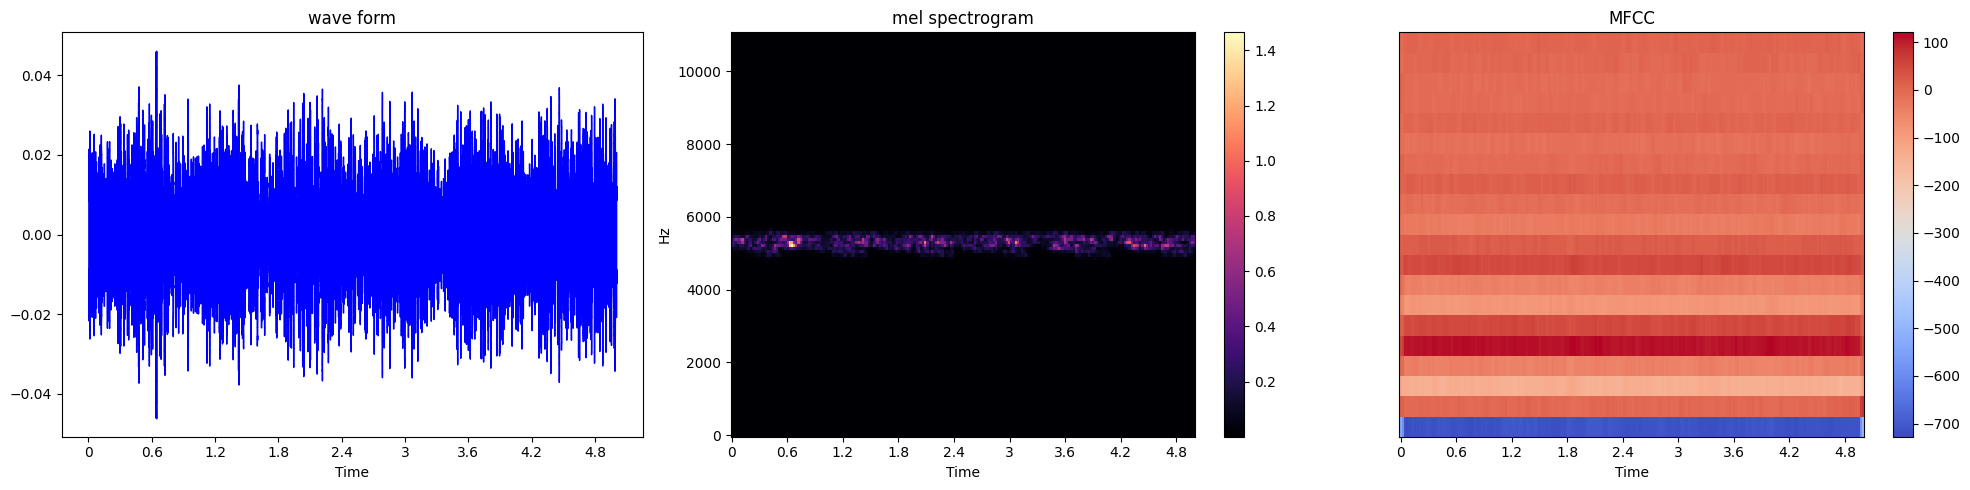

category : hen


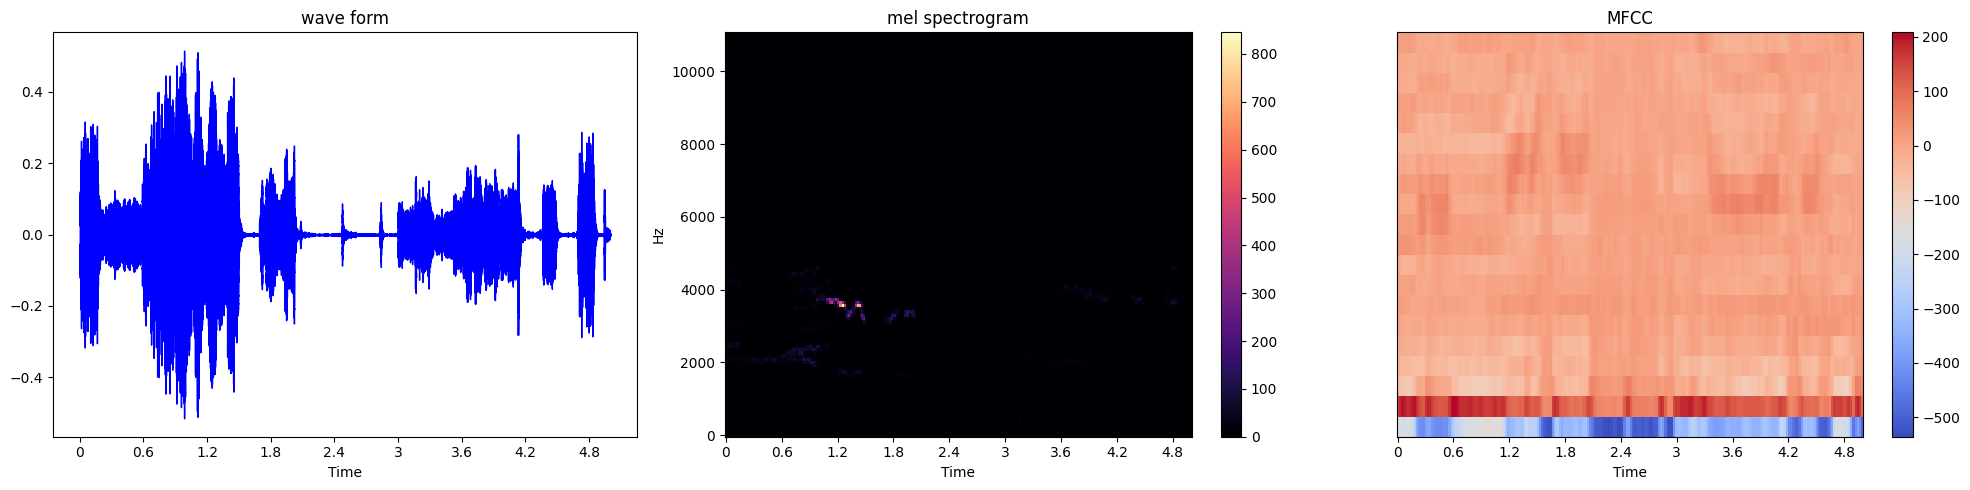

category : train


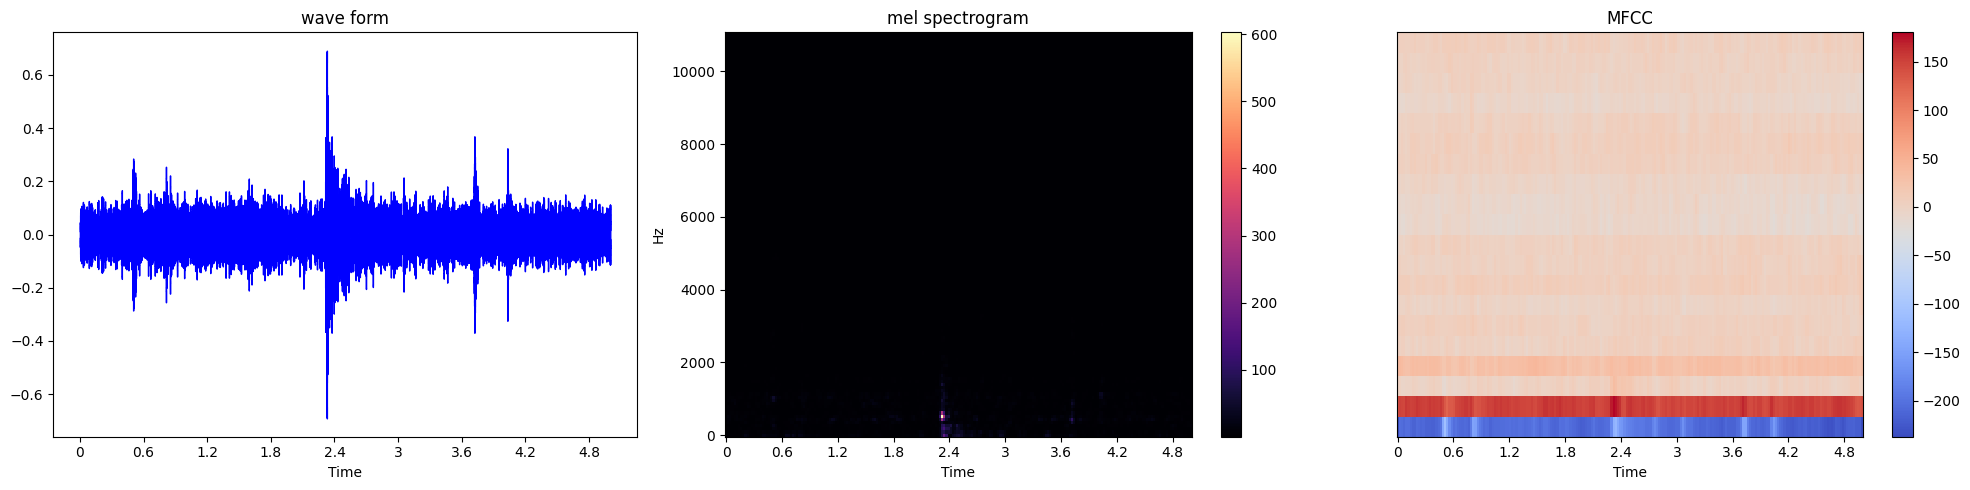

In [7]:
# とりあえず1つの音源ファイルを指定してlibrosaを使ってみる
#librosa.loadで音源の波形データ（第1戻り値）とサンプルレート（第2戻り値）を取得できる
waveform, sample_rate = librosa.load(drive_dir + "audio/1-100032-A-0.wav") # 犬の鳴き声の音源データを指定

# メルスペクトログラムの取得
# librosa.feature.melspectrogramに上で取得した波形データとサンプルレートを渡せば
# 一発でメルスペクトログラムを取得できる
feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

# MFCCの取得
# librosa.feature.mfccでOK
feature_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)

# 波形データ、メルスペクトログラム、MFCCはnumpy形式で得られる
print("波形データのデータタイプ", type(waveform))
print("メルスペクトログラムのデータタイプ", type(feature_melspec))
print("MFCCのデータタイプ", type(feature_mfcc))
print("サンプルレート", sample_rate)
print("波形データの形状", waveform.shape)
print("メルスペクトログラムの形状", feature_melspec.shape)
print("MFCCの形状", feature_mfcc.shape)

# ランダムに3つほど音源データをピックアップし、波形、メルスペクトログラム、MFCCを可視化する
# ついでにnotebook上で音源の再生ができるようにする
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
  filename = row[1][0] # wavファイル名
  category = row[1][1] # そのファイルのカテゴリ

  # 波形データとサンプルレートを取得
  waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)

  # メルスペクトログラムを取得
  feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

  # MFCCを取得
  feature_mfcc = librosa.feature.mfcc(y=waveform, sr=sample_rate)

  # 可視化
  print("category : " + category)
  plt.figure(figsize=(20, 5))

  # librosa.display.waveplotで波形データを可視化できる
  plt.subplot(1,3,1)
  plt.title("wave form")
  librosa.display.waveshow(waveform, sr=sample_rate, color='blue')

  # librosa.display.specshowでメルスペクトログラム、MFCCを可視化できる
  plt.subplot(1,3,2)
  plt.title("mel spectrogram")
  librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar()

  plt.subplot(1,3,3)
  plt.title("MFCC")
  librosa.display.specshow(feature_mfcc, sr=sample_rate, x_axis='time')
  plt.colorbar()

  plt.tight_layout()
  plt.show()
  print()

  # 音源の再生はlibrosaで取得できた波形データとサンプルレートを
  # IPython.display.Audioに以下のようにして渡す
  display(ipd.Audio(waveform, rate=sample_rate))

実際に再生してみるとよい

メルスペクトログラムやMFCCはある種チャネル数1の画像データとみなすことができ、画像とみなした時の隣接ピクセルは密接な関係性があり、離れたピクセル同士はそうではない、という特徴があると考えられ、であるならば、CNNが利用できる

## メルスペクトログラムのデシベルスケール変換

上記のメルスペクトログラムをそのまま用いると、0付近の値が多いためうまくCNNを用いても学習できないためさらなる工夫が必要
- 周波数に関しては人間の聴覚特性に応じて変換した
- であれば音圧も人間の聴覚特性に応じて変換すればよい、ならばデシベルだ

そもそも人間の聴覚特性で変換することがよいのか悪いのかという疑問もあるが、人が進化で獲得した能力なのだから、従うのがよいのでは？と納得し、そもそも、情報が多すぎて必要な情報をうまく勘案できない事態は避けたい

librosaでは、メルスペクトログラムにlibrosa.power_to_dbを施せばデシベルスケールに変換できる
- つまり基本的にはlibrosa.feature.melspectrogramでメルスペクトログラムを抽出、librosa.power_to_dbでデシベルスケールに変換、この手順を施したデータをメルスペクトログラム呼ぶ場合も多い

実際にメルスペクトログラムの音圧をデシベルスケールに変換して可視化すると次のようになり、CNNを用いて解析できそうな画像となる

category : insects


/tmp/ipython-input-1300397727.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filename = row[1][0] # wavファイル名
/tmp/ipython-input-1300397727.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  category = row[1][1] # そのファイルのカテゴリ


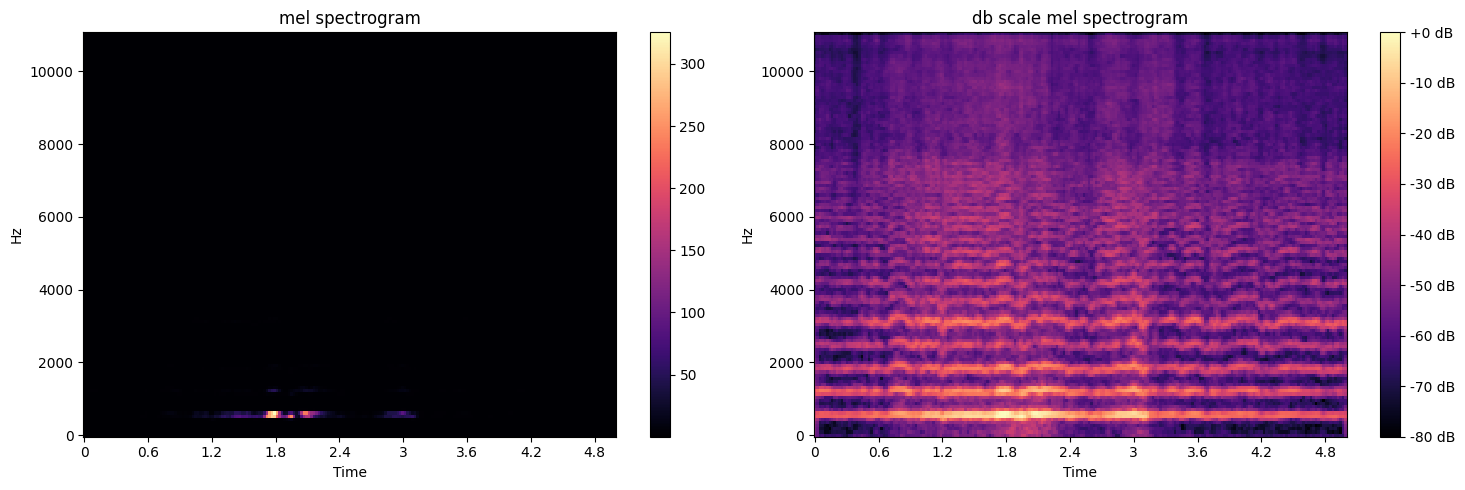

category : pig


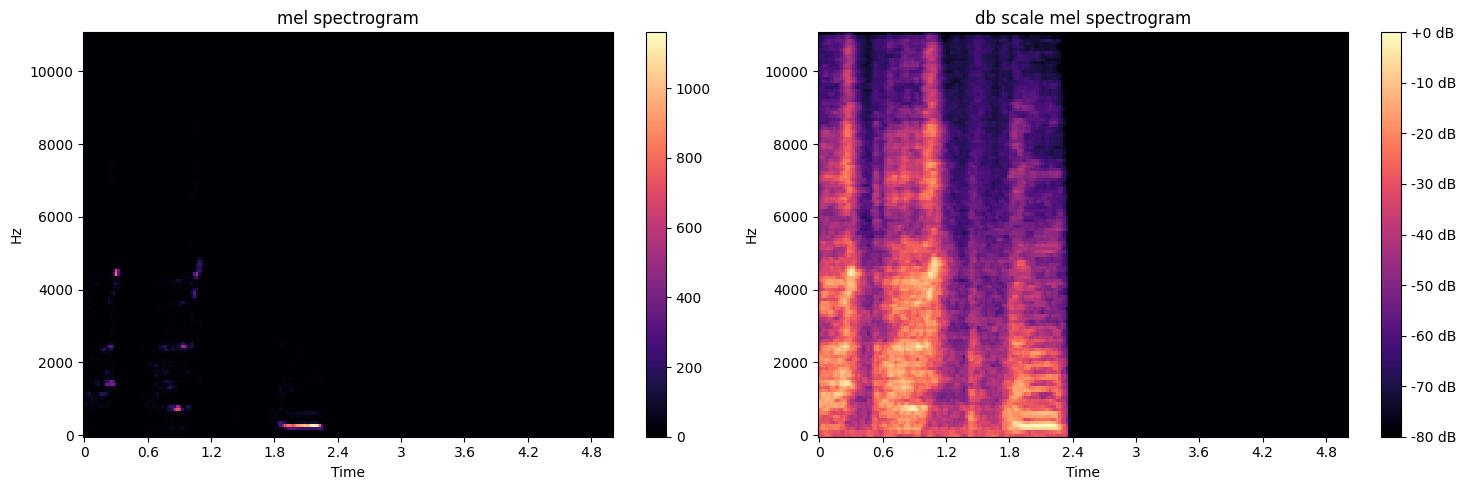

category : clock_tick


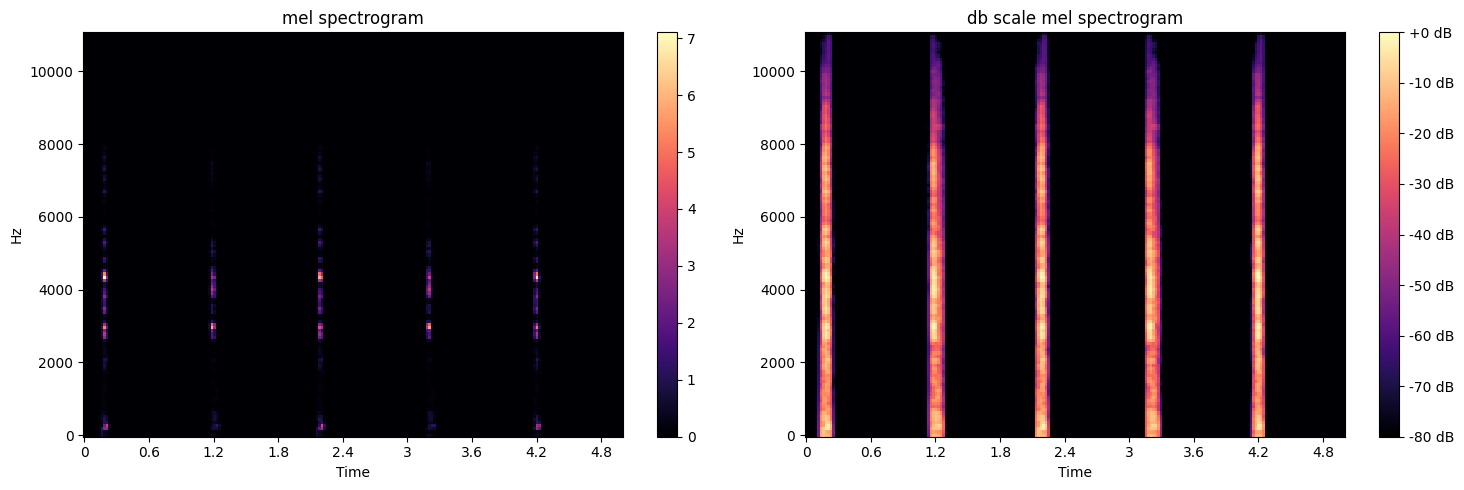

In [8]:
for row in meta_df.sample(frac=1)[['filename', 'category']][:3].iterrows():
  filename = row[1][0] # wavファイル名
  category = row[1][1] # そのファイルのカテゴリ

  waveform, sample_rate = librosa.load(drive_dir + "audio/" + filename)

  # メルスペクトログラムを求める
  feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)

  print("category : " + category)
  plt.figure(figsize=(15,5))

  # librosa.feature.melspectrogramをそのまま可視化した場合
  plt.subplot(1,2,1)
  plt.title("mel spectrogram")
  librosa.display.specshow(feature_melspec, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar()

  # デシベルスケールに変換した場合
  plt.subplot(1,2,2)
  plt.title("db scale mel spectrogram")
  feature_melspec_db = librosa.power_to_db(feature_melspec, ref=np.max)
  librosa.display.specshow(feature_melspec_db, sr=sample_rate, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')

  plt.tight_layout()
  plt.show()

# CNNを用いた分類

ここでは、学習済みモデルであるResNetを利用して強化学習させる
- 準備に10分弱かかる

In [9]:
class ESC50Data(Dataset):
  def __init__(self, base_path, df, in_col, out_col):
    self.df = df
    self.data = [] # 音源データをメルスペクトログラム（画像）に変換して格納
    self.labels = [] # 各データのカテゴリー情報を格納する
    self.category2id={}
    self.id2category={}
    self.categories = list(sorted(df[out_col].unique())) # 正解ラベル格納用（５０ラベル）
    # ラベルをIDに変換する辞書を作成
    for i, category in enumerate(self.categories):
      self.category2id[category] = i
      self.id2category[i] = category

    # メタ情報ファイルからファイル名を取得し、wavデータを1件ずつ画像に変換
    for row in tqdm(range(len(df))):
      row = df.iloc[row]
      file_path = os.path.join(base_path, row[in_col])
      waveform, sr = librosa.load(file_path)

      # メルスペクトログラムを取得してデシベルスケールに変換
      feature_melspec = librosa.feature.melspectrogram(y=waveform, sr=sr)
      feature_melspec_db = librosa.power_to_db(feature_melspec, ref=np.max)

      self.data.append(feature_melspec_db)
      self.labels.append(self.category2id[row['category']])

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

# メタ情報ファイルを学習データとテストデータに分ける
train_df, test_df = train_test_split(meta_df, train_size=0.8)

# メタ情報ファイルから音源データをDataLoaderに変換する
train_data = ESC50Data(drive_dir + "audio/", train_df, 'filename', 'category')
test_data = ESC50Data(drive_dir + "audio/", test_df, 'filename', 'category')
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

100%|██████████| 400/400 [00:07<00:00, 52.52it/s]


In [10]:
from torchvision.models import resnet34

# 学習済みのResNetをダウンロード
resnet_model = resnet34(pretrained=True)

# ResNetの構造を出力して確認
print(resnet_model)
# 最初の畳み込みのチャネル3をチャネル1に変更
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# 最後の層の次元を今回のカテゴリ数に変更
resnet_model.fc = nn.Linear(512,50)

# GPUを利用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=2e-4)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 151MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 学習と検証

5分程度かかる

In [11]:
losses = []
for epoch in range(50):

  # 学習
  train_losses = 0

  for data in train_loader:
    optimizer.zero_grad()
    x, y = data
    x = x.to(device, dtype=torch.float32)
    y = y.to(device)
    x = x.unsqueeze(1) # チャネル数1を挿入
    out = resnet_model(x)
    loss = loss_function(out, y)
    loss.backward()
    optimizer.step()
    train_losses += loss.item()

  # 検証
  test_losses = 0
  actual_list, predict_list = [], []

  for data in test_loader:
    with torch.no_grad():
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device)
      x = x.unsqueeze(1)
      out = resnet_model(x)
      loss = loss_function(out, y)
      _, y_pred = torch.max(out, 1)
      test_losses += loss.item()

      actual_list.append(y.cpu().numpy())
      predict_list.append(y_pred.cpu().numpy())

  actual_list = np.concatenate(actual_list)
  predict_list = np.concatenate(predict_list)
  accuracy = np.mean(actual_list == predict_list)

  print("epoch", epoch, "\t train_loss", train_losses,
        "\t test_loss", test_losses, "\t accuracy", accuracy)

epoch 0 	 train_loss 132.71874153614044 	 test_loss 22.1823890209198 	 accuracy 0.55
epoch 1 	 train_loss 52.542804479599 	 test_loss 16.720770001411438 	 accuracy 0.65
epoch 2 	 train_loss 25.752962946891785 	 test_loss 13.764627397060394 	 accuracy 0.6875
epoch 3 	 train_loss 15.702628135681152 	 test_loss 13.572592794895172 	 accuracy 0.7075
epoch 4 	 train_loss 8.881362944841385 	 test_loss 13.558867990970612 	 accuracy 0.6975
epoch 5 	 train_loss 11.654280301183462 	 test_loss 14.01999694108963 	 accuracy 0.71
epoch 6 	 train_loss 15.481296174228191 	 test_loss 14.677692294120789 	 accuracy 0.6975
epoch 7 	 train_loss 10.162293899804354 	 test_loss 13.134636402130127 	 accuracy 0.7275
epoch 8 	 train_loss 5.384542193263769 	 test_loss 11.742704808712006 	 accuracy 0.7575
epoch 9 	 train_loss 4.770014858804643 	 test_loss 13.610127091407776 	 accuracy 0.725
epoch 10 	 train_loss 4.217906313017011 	 test_loss 13.666106641292572 	 accuracy 0.7225
epoch 11 	 train_loss 3.6300961915403

# 演習課題

ResNetの利用は大変コストがかかり、実行速度が遅いため、精度は気にせず、自分なりのモデルを構築して学習させなさい
- 精度はマルチラベルで50%以上達成すればよい
- なお、時間に余裕がある場合は、ResNetのままでも構わない。

また、実際に自身で生活音などを録音してwavファイルを生成、上記のモデルを利用して、正解するかどうか確認しなさい

# 演習問題

データ拡張を用いて精度を向上させなさい

# 参考となる関数やテクニック


関係する関数群として次の項目をまとめておく
- 波形の読み込み
- メルスペクトグラムへの変換
- 波形の表示
- ヒートマップの表示

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


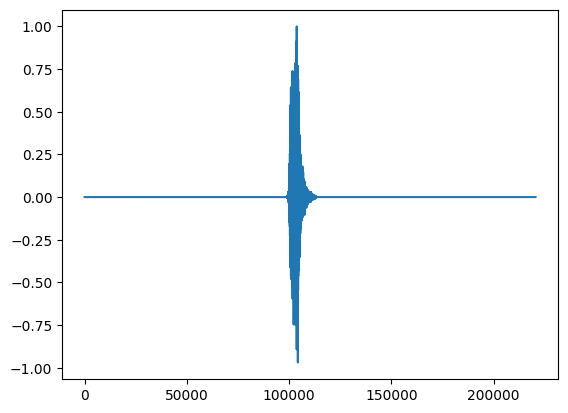

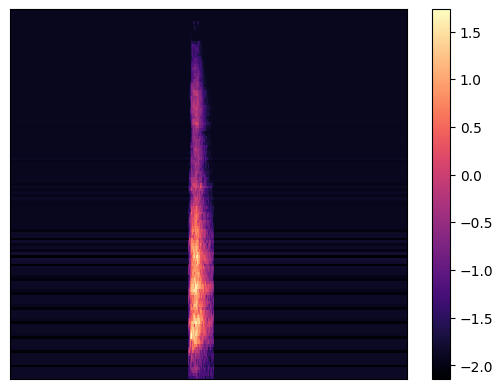

In [12]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
audio_dir = 'ESC-50-master/audio'
meta_file = 'ESC-50-master/meta/esc50.csv'
meta_data = pd.read_csv(meta_file)
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

## STFTについて

一般に、音声データに短時間フーリエ変換（Short-time Fourier transform : STFT）を施してスペクトログラムを得る
- 先の例では、librosaの機能を使って一発で変換したが、実際には内部でSTFTが利用されている

STFTの手順
- 音声信号のある時間範囲を窓で区切り、その窓の範囲でフーリエ変換を行うことで、該当する時間範囲での周波数スペクトルを求める
- 窓をずらしながら計算繰り返すことで、周波数スペクトルの時間経過の行列Dを得る
- 次のようなパラメタが存在する
  - n_fft（窓の長さ） デフォルト値は2048
  - hop_length（窓の移動幅） デフォルト値はn_fft/4
  - librosaのstft関数は2次元テンソルを返す

<img src="http://class.west.sd.keio.ac.jp/dataai/text/stft.webp" width=600>

In [13]:
def griffinlim(spectrogram, n_iter = 100, window = 'hann', n_fft = 2048, hop_length = -1, verbose = False):
    if hop_length == -1:
        hop_length = n_fft // 4
    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))
    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    for i in t:
        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length = hop_length, window = window)
        rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
        angles = np.exp(1j * np.angle(rebuilt))
        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    return inverse

## STFTの逆変換

逆にSTFT変換されたデータから音声情報を復元することができる

- 位相情報が使える場合
  - 直交形式に変換(librosaには含まれていない)してからlibrosa.istft()を利用する
  - 強度S,位相phaseから$z=re^{i\theta}$として直交形式の複素数の行列Dへ変換
  - そのあとISTFTで復元
  
```
D = S * np.exp(1j*phase)
y_inv = librosa.istft(D)
```

- 位相情報が使えない場合
  - 次のgriffinlim()で位相推定して音声を復元、次のようなコードになる

In [14]:
def griffinlim(spectrogram, n_iter = 100, window = 'hann', n_fft = 2048, hop_length = -1, verbose = False):
    if hop_length == -1:
        hop_length = n_fft // 4
    angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))
    t = tqdm(range(n_iter), ncols=100, mininterval=2.0, disable=not verbose)
    for i in t:
        full = np.abs(spectrogram).astype(np.complex) * angles
        inverse = librosa.istft(full, hop_length = hop_length, window = window)
        rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
        angles = np.exp(1j * np.angle(rebuilt))
        if verbose:
            diff = np.abs(spectrogram) - np.abs(rebuilt)
            t.set_postfix(loss=np.linalg.norm(diff, 'fro'))
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    return inverse

## 周波数ビン・時刻ビンの計算

このようにして得られたメルスペクトグラムの画像がどの程度の解像度を持つのかを求める必要がある場合がある

「周波数ビンの数」「時刻ビンの数」「周波数ビンの幅」「時刻ビンの幅」は以下のように計算できる

$$ 表現可能な周波数 = サンプリング周波数/2 $$

$$ 窓の移動幅のデータ数(hop\_len) = 窓幅のデータ数(n\_fft)/窓の移動幅の比$$

$$周波数ビンの数(Hz\_bin) = 1+n\_fft/2 $$

$$1秒あたりの時刻ビンの数(num\_bin) = サンプリング周波数(sr)/lop\_len$$

$$周波数ビンの幅[Hz] = 表現可能な周波数/Hz\_bin$$

$$時刻ビンの幅[ms] = 1000[ms]/num\_bin$$

例えば、librosa.stft()はデフォルト値で以下のような仕様になる
- 0～約11kHzの範囲を約1025分割
  - 周波数分解能は約10.76Hz
- １秒間を約43分割して表現
  - 時間分解能は約23.26ms

これらを参考に、srやn_fftを調整して目標の分解能やデータサイズを得るようにする



## 音声データ拡張

データ拡張として、次ような手法がある
- ホワイトノイズを入れる
  - ホワイトノイズは全周波数帯域に渡り均一に乱雑な音が含まれる
  - ノイズ環境でも識別できるようになると考えられる(ノイズに対してロバストになる)
  - 乱数を加えることで実現
- 周波数シフトする
  - 例えば動物の鳴き声で判別するような場合、大小の個体や年齢の差といった周波数成分分布に関する差を考慮することができる
  - np.rollで配列要素をシフトすることで実現
- 時間方向に伸張する
  - 例えばゆっくり話すのと速く話すなどの違いを吸収する
  - librosaの機能を利用して実現

In [15]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
  return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
  return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
  input_length = len(x)
  x = librosa.effects.time_stretch(x, rate=rate)
  if len(x)>input_length:
    return x[:input_length]
  else:
    return np.pad(x, (0, max(0, input_length - len(x))), "constant")

## 順番にメルスペクトラムを求める

wavデータにメル周波数のフィルタバンクをかけてメルスペクトログラムを生成するには、次のようにすることもできる

In [16]:
# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

## データ生成

wavデータをAugmentationしメルスペクトログラムにして分類器の入力データとするには次のようにする
- ここでは前処理として全wavファイルをAugmentation、メルスペクトログラムにしたデータを生成している
- 学習データとテストデータに分割、ここではテストデータは25％とし、stratify=yとすることで各クラスを均等に分割している

In [17]:
from sklearn import model_selection
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(
    len(x_train), len(y_train), len(x_test), len(y_test)))
# showing the classes are equally splitted
a = np.zeros(50)
for c in y_test:
    a[c] += 1
print(a)

x train:1500
y train:1500
x test:500
y test:500
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


## データ拡張とnpzによる保存

- 学習データ、テストデータをまとめてnpzにして保存
- 学習データはさらにホワイトノイズ、シフト、ストレッチ、それらの組合せをかけて、別に保存

結果として以下のデータがnpz形式で用意されており、テストデータ500点、学習データ7,500点で構成されている
- テストデータのメルスペクトログラム（500点）
- 学習データのメルスペクトログラム（1,500点）
- ホワイトノイズののった学習データのメルスペクトログラム（1,500点）
- シフトされた学習データのメルスペクトログラム（1,500点）
- ストレッチされた学習データのメルスペクトログラム（1,500点）
- ホワイトノイズ、シフト、ストレッチがランダムに組み合わさった学習データのメルスペクトログラム（1,500点）



実行途中で、torch-devがインストールされるため再起動を促される場合がある

ここでは無視して先に進むが、問題がある場合は次のようにして一度ここで中断し、次のセルから再度実行すること
- 現状はコメントアウトされている

In [18]:
from google.colab import runtime
#runtime.unassign()

# Demucs

音楽からドラム、ベース、ボーカルを高精度に分離できるモデルを用いて、ハイブリッド音源分離を実際に扱う

ドメインが各音源に最も適しているかをモデルに決定させ、ドメインと各音源の両方を組み合わせることで、ハイブリッド音源分離を行う
- 圧縮残差ブランチ、Local Attention、特異値正則化といった工夫も施されている

## 構造


U-Net アーキテクチャを2次元である画像ではなく1次元である音声の時間領域に適応させて、エンドツーエンドの音源分離を実行するWave-U-Netを基本としている

これに、ハイブリッド スペクトログラム/波形分離、圧縮残差ブランチ、ローカル アテンション、および特異値正則化を施している


ハイブリッドDemucsの構造は次のとおりである

- 入力波形は、時間エンコーダーとして、最初にSTFT、次にスペクトルエンコーダーの両方で処理される
  - 2つの表現は、次元が揃った時点で合計される
- デコーダはU-Netを基本としており、左右対称の構造を有する
- 出力されたスペクトログラムはISTFTを通り、波形出力と合計され、最終的なモデル出力となる
- Z接頭辞はスペクトル層に、T接頭辞は時間層に使用される

<img src="http://class.west.sd.keio.ac.jp/dataai/text/demucs1.jpg" width="900">

ライブラリの読み込みと、補助関数の定義を行う

In [19]:
# install demucs
! pip install demucs

# clone github code
! git clone https://github.com/cedro3/demucs.git
%cd demucs

# import library
import io
from pathlib import Path
import select
from shutil import rmtree
import subprocess as sp
import sys
from typing import Dict, Tuple, Optional, IO
from google.colab import files
import os
import shutil

# define function
def find_files(in_path):
    out = []
    for file in Path(in_path).iterdir():
        if file.suffix.lower().lstrip(".") in extensions:
            out.append(file)
    return out

def copy_process_streams(process: sp.Popen):
    def raw(stream: Optional[IO[bytes]]) -> IO[bytes]:
        assert stream is not None
        if isinstance(stream, io.BufferedIOBase):
            stream = stream.raw
        return stream

    p_stdout, p_stderr = raw(process.stdout), raw(process.stderr)
    stream_by_fd: Dict[int, Tuple[IO[bytes], io.StringIO, IO[str]]] = {
        p_stdout.fileno(): (p_stdout, sys.stdout),
        p_stderr.fileno(): (p_stderr, sys.stderr),
    }
    fds = list(stream_by_fd.keys())

    while fds:
        # `select` syscall will wait until one of the file descriptors has content.
        ready, _, _ = select.select(fds, [], [])
        for fd in ready:
            p_stream, std = stream_by_fd[fd]
            raw_buf = p_stream.read(2 ** 16)
            if not raw_buf:
                fds.remove(fd)
                continue
            buf = raw_buf.decode()
            std.write(buf)
            std.flush()

def separate(inp=None, outp=None):
    inp = inp or in_path
    outp = outp or out_path
    cmd = ["python3", "-m", "demucs.separate", "-o", str(outp), "-n", model]
    if mp3:
        cmd += ["--mp3", f"--mp3-bitrate={mp3_rate}"]
    if float32:
        cmd += ["--float32"]
    if int24:
        cmd += ["--int24"]
    if two_stems is not None:
        cmd += [f"--two-stems={two_stems}"]
    files = [str(f) for f in find_files(inp)]
    if not files:
        print(f"No valid audio files in {in_path}")
        return
    print("Going to separate the files:")
    print('\n'.join(files))
    print("With command: ", " ".join(cmd))
    p = sp.Popen(cmd + files, stdout=sp.PIPE, stderr=sp.PIPE)
    copy_process_streams(p)
    p.wait()
    if p.returncode != 0:
        print("Command failed, something went wrong.")

def reset_folder(path):
    if os.path.isdir(path):
      shutil.rmtree(path)
    os.makedirs(path,exist_ok=True)

# make directory
! mkdir target
! mkdir separated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for demucs: filename=demucs-4.0.1-py3-none-any.whl size=78388 sha256=519340aa12ab727a27d1c9c5683250b8be617489b188f653791b7ab6a4eda663
  Stored in directory: /root/.cache/pip/wheels/1b/0c/20/a3b3daa1f9b65c8b0445729f94740ec335d0f86f1066c5c414
  Created wheel for julius: filename=julius-0.2.7-

In [20]:
!pip install diffq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffq: filename=diffq-0.2.4-cp312-cp312-linux_x86_64.whl size=467837 sha256=eb4cd3d4e4246c58e5729261c8626fdfe0f436005ee15400f37289b063634aca
  Stored in directory: /root/.cache/pip/wheels/e1/2d/ce/ffafea46a65fecd3c416036f48b3d93471cf47b8c9dcd50e60
Successfully built diffq


In [21]:
!pwd

/content/demucs


音源分離を行う

まず、音楽データを指定する

ボーカルを抜く場合は、既に英語である"karaoke"をチェックしておく

In [22]:
#@markdown 音楽ファイルの指定

# setting
input = 'sazanami.mp3' #@param {type:"string"}
reset_folder('target')
reset_folder('separated')
shutil.copy('./music/'+input, './target/'+input)
karaoke = False #@param {type:"boolean"}

In [23]:
# Customize the following options!
model = "mdx_extra"
extensions = ["mp3", "wav", "ogg", "flac"]  # we will look for all those file types.

if karaoke:
  two_stems = "vocals"
else:
  two_stems = None   # only separate one stems from the rest, for instance

# Options for the output audio.
mp3 = True
mp3_rate = 320
float32 = False  # output as float 32 wavs, unsused if 'mp3' is True.
int24 = False    # output as int24 wavs, unused if 'mp3' is True.
# You cannot set both `float32 = True` and `int24 = True` !!

in_path = './target/'
out_path = './separated/'

separate()

Going to separate the files:
target/sazanami.mp3
With command:  python3 -m demucs.separate -o ./separated/ -n mdx_extra --mp3 --mp3-bitrate=320
Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/e51eebcc-c1b80bdd.th" to /root/.cache/torch/hub/checkpoints/e51eebcc-c1b80bdd.th


100%|██████████| 160M/160M [00:02<00:00, 82.2MB/s]


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/a1d90b5c-ae9d2452.th" to /root/.cache/torch/hub/checkpoints/a1d90b5c-ae9d2452.th


100%|██████████| 160M/160M [00:02<00:00, 56.9MB/s]


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/5d2d6c55-db83574e.th" to /root/.cache/torch/hub/checkpoints/5d2d6c55-db83574e.th


100%|██████████| 160M/160M [00:00<00:00, 180MB/s]


Downloading: "https://dl.fbaipublicfiles.com/demucs/mdx_final/cfa93e08-61801ae1.th" to /root/.cache/torch/hub/checkpoints/cfa93e08-61801ae1.th


100%|██████████| 160M/160M [00:00<00:00, 176MB/s]


Selected model is a bag of 4 models. You will see that many progress bars per track.
Separated tracks will be stored in /content/demucs/separated/mdx_extra
Separating track target/sazanami.mp3


100%|████████████████████████████████████████████████████████████████████████| 297.0/297.0 [00:08<00:00, 35.10seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 297.0/297.0 [00:08<00:00, 35.37seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 297.0/297.0 [00:07<00:00, 38.35seconds/s]
100%|████████████████████████████████████████████████████████████████████████| 297.0/297.0 [00:07<00:00, 39.27seconds/s]


分離された音源を再生する

karaokeオプションをONにした場合、vocalsか、no_vocalsを選択でき、そうではない場合bass, drums, other, vocalsを選択できる

In [24]:
from IPython.display import Audio
part ="bass"#@param ["bass", "drums", "other", "vocals", "no_vocals"]
file_path = './separated/mdx_extra/'+os.path.splitext(input)[0]+'/'+part+'.mp3'
Audio(file_path)

Output hidden; open in https://colab.research.google.com to view.

分離した音源をダウンロードする
- 実行時間削減の観点から、separated.zipが生成されるため、フォルダから直接ダウンロードするとよい

In [25]:
from google.colab import files

if os.path.isfile('separated.zip'):
  os.remove('separated.zip')

! zip -r separated.zip separated/mdx_extra
#files.download('separated.zip')

  adding: separated/mdx_extra/ (stored 0%)
  adding: separated/mdx_extra/sazanami/ (stored 0%)
  adding: separated/mdx_extra/sazanami/bass.mp3 (deflated 4%)
  adding: separated/mdx_extra/sazanami/other.mp3 (deflated 1%)
  adding: separated/mdx_extra/sazanami/drums.mp3 (deflated 1%)
  adding: separated/mdx_extra/sazanami/vocals.mp3 (deflated 2%)
